# RNNs
Chúng ta sử dụng mạng Neural hội qui và mở rộng của nó là LSTMs để thực hiện phân tích quan điểm trên Keras. Để thuận tiện, chương trình trên Keras được xây dựng với bộ dữ liệu review IMDB.

In [1]:
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
vocabulary_size = 5000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

Loaded dataset with 25000 training samples, 25000 test samples


Kiểm tra mẫu review và nhãn của nó: 

In [3]:
print('---review---')
print(X_train[6])
print('---label---')
print(y_train[6])

---review---
[1, 2, 365, 1234, 5, 1156, 354, 11, 14, 2, 2, 7, 1016, 2, 2, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 2, 2, 1117, 1831, 2, 5, 4831, 26, 6, 2, 4183, 17, 369, 37, 215, 1345, 143, 2, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 2, 2, 63, 271, 6, 196, 96, 949, 4121, 4, 2, 7, 4, 2212, 2436, 819, 63, 47, 77, 2, 180, 6, 227, 11, 94, 2494, 2, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 2, 99, 76, 23, 2, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
---label---
1


Map word IDs back to words

In [4]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in X_train[6]])
print('---label---')
print(y_train[6])

---review with words---
['the', 'and', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'and', 'and', 'br', 'villain', 'and', 'and', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'and', 'and', 'concept', 'issue', 'and', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'and', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', 'and', 'and', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'and', 'things', 'is', 'far', 'this', 'make', 'mistakes', 'and', 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'and', 'movies', 'get', 'are', 'and', 'br', 'yes', 'female', 'just', 'its', 'because', 'many', 'br', 'of', 'overly', 'to', 'descent', 'people', 'time', 

Độ dài lớn nhất và nhỏ nhất của review:

In [5]:
print('Maximum review length: {}'.format(
len(max((X_train + X_test), key=len))))

Maximum review length: 2697


In [6]:
print('Minimum review length: {}'.format(
len(min((X_train + X_test), key=len))))

Minimum review length: 70


# Configs
This part is to set up configuration & parameters, such as import, arguments, hyperparameters, etc.

In [7]:
import tensorflow as tf
# Enforce dynamic session for Keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
# Hyperparams
max_words = 500
batch_size = 64
num_epochs = 3
# Model params
embedding_size=32
inner_lstm_size=128 # actually doubled to 256 due to bidirectional
dropout=0.2

# Ver.1: Pad sequences
In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this using the pad_sequences() function in Keras. For now, set max_words to 500.

In [8]:
from keras.preprocessing import sequence

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Ver.2: Timeseries data
Same as above, but instead creating a `Dataset` object for the task using `tf.keras.preprocessing.timeseries_dataset_from_array`

In [9]:
#from keras.preprocessing import timeseries_dataset_from_array
#print([i for i in vars(keras.preprocessing.sequence) if callable(i)])
#training_data = timeseries_dataset_from_array(X_train, y_train, sequence_length=max_words, 
#                                              batch_size=batch_size, start_index=batch_size)
#for i, (X, y) in enumerate(training_data):
#    print(X, y)
#    if(i > 3): break

# Thiết kê mô hình RNN(LSTM) cho phân tích quan điểm.

Build our model architecture in the code cell below. We have imported some layers from Keras that you might need but feel free to use any other layers / transformations you like.

Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = max_words, and our output is a binary sentiment label (0 or 1).


In [10]:
#from keras import Sequential
#from keras.layers import Embedding, LSTM, Dense, Dropout
import keras
#model=Sequential()
#model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
#model.add(LSTM(100)) #model.add(LSTM(100))
#model.add(Dense(1, activation='sigmoid'))
inputs = keras.layers.Input(shape=[None], dtype='int32')
# the mask_zero is to remove padding from the sequence.
embedded = keras.layers.Embedding(vocabulary_size, embedding_size, mask_zero=True)(inputs)
dropout_emb = keras.layers.Dropout(dropout)(embedded)
top = keras.layers.Bidirectional( keras.layers.LSTM(inner_lstm_size, return_sequences=True) )(dropout_emb)
attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(top)
#context = tf.squeeze( tf.matmul(top, tf.expand_dims(attention, axis=2), transpose_a=True), axis=[-1])
context = keras.layers.Flatten() ( keras.layers.dot([top, attention], axes=1) )
pred = keras.layers.Dense(1, activation='sigmoid')(context)

model = keras.Model(inputs=inputs, outputs=pred)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     160000      input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 32)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 256)    164864      dropout_1[0][0]                  
__________________________________________________________________________________________________
time_distr

# Huấn luyện và đánh giá model
We first need to compile our model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics we'd like to measure. Specify the approprate parameters, including at least one metric 'accuracy'.

In [11]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [12]:
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]

history_obj = model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), 
                        batch_size=batch_size, epochs=num_epochs)

Train on 24936 samples, validate on 64 samples
Epoch 1/3
24936/24936 [==============================] - 916s 37ms/step - loss: 0.3844 - acc: 0.8181 - val_loss: 0.2262 - val_acc: 0.9219
Epoch 2/3
24936/24936 [==============================] - 914s 37ms/step - loss: 0.2272 - acc: 0.9129 - val_loss: 0.2594 - val_acc: 0.9219
Epoch 3/3
24936/24936 [==============================] - 920s 37ms/step - loss: 0.1805 - acc: 0.9305 - val_loss: 0.2652 - val_acc: 0.8906


In [13]:
print(vars(history_obj))

{'model': <keras.engine.training.Model object at 0x7fa1bce986d8>, 'validation_data': [array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,  437,    7,   58],
       [   0,    0,    0, ...,   11,    6,    2],
       [   0,    0,    0, ...,    4,    2, 1117]], dtype=int32), array([[1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],

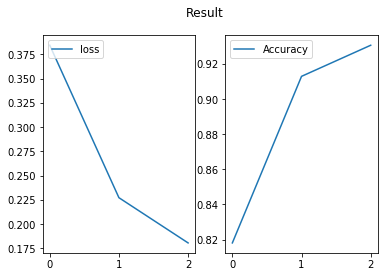

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].plot(history_obj.history['loss'], label='loss')
axes[1].plot(history_obj.history['acc'], label='Accuracy')
fig.suptitle('Result')
#plt.ylabel('MSE value')
for ax in axes:
    ax.set_xticks(range(3))
    #plt.xlabel('No. epoch')
    ax.legend(loc="upper left")
plt.show()

scores[1] will correspond to accuracy if we pass metrics=['accuracy']

In [20]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.88436
